In [1]:
# Import relevant libraries
import pandas as pd
pd.set_option('precision', 4)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Import data, drop irrelevant variables, interactions, missing values
datam = pd.read_stata('expattdata.dta')
drop = ['att', 'gamedatenum', 'expdate', 'downloaddatenum', 'homebackgtg', 'homeaheadgtg', 'awaybackgtg', 'awayaheadgtg']
for i in drop: del datam[i]
datam = datam.dropna()
print(list(datam.columns))

['away', 'home', 'year', 'propmaxatt', 'homeopener', 'block', 'homediv', 'homeleague', 'homerecord', 'homegameback', 'homegametogo', 'homewildgameback', 'homegameahead', 'homewildgameahead', 'homepriortofirstgame', 'awaydiv', 'awayleague', 'awayrecord', 'awaygameback', 'awaygametogo', 'awaywildgameback', 'awaygameahead', 'awaywildgameahead', 'awaypriortofirstgame', 'interl', 'samediv', 'dow', 'month']


In [3]:
# Convert multi-level dummies to hot-one encoded dummies (Note: block = spans of ~20 games)
var_list = ['away', 'home', 'dow', 'month', 'year', 'block', 'homediv', 'awaydiv']
for i in var_list:
    datam = pd.concat([datam,pd.get_dummies(datam[i], prefix=i,dummy_na=False)],axis=1).drop([i],axis=1)

In [4]:
# Split data into training and test set
train_set, test_set = train_test_split(datam, test_size=0.2, random_state=21)

In [5]:
# Split training and test sets into labels and variables
cols = [col for col in datam.columns if col != 'propmaxatt']
y_train, X_train = train_set['propmaxatt'], train_set[cols]
y_test, X_test = test_set['propmaxatt'], test_set[cols]

In [6]:
# Train Linear Regression
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [7]:
# Assess performance of linear regression
r_2 = reg.score(X_test, y_test)
mse = ((reg.predict(X_test)-y_test)**2).mean()
print('The Linear Regression has an MSE of %0.4f on the test set.' %mse)
print('The Linear Regression has an R-squared value of %0.4f on the test set.' %r_2)

The Linear Regression has an MSE of 0.0218 on the test set.
The Linear Regression has an R-squared value of 0.6294 on the test set.


In [8]:
# # Code to check cross-validated scores (omitted in final runthrough due to runtime)
# forest = RandomForestRegressor(max_features=120, n_estimators=32)
# scores = cross_val_score(forest, X_train, y_train, cv=10)
# print(scores.mean())

In [9]:
# Train random forest
forest = RandomForestRegressor(max_features=100, n_estimators = 64)
forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=100, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=64, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [10]:
# Assess performance of random forest
r_2 = forest.score(X_test, y_test)
mse = ((forest.predict(X_test)-y_test)**2).mean()
print('The Random Forest has an MSE of %0.4f on the test set.' %mse)
print('The Random Forest has an R-squared value of %0.4f on the test set.' %r_2)

The Random Forest has an MSE of 0.0009 on the test set.
The Random Forest has an R-squared value of 0.9854 on the test set.


In [11]:
# Generate variable importances for random forest
imps = pd.DataFrame(forest.feature_importances_,
                    index = X_train.columns,
                    columns=['importance']).sort_values('importance', ascending=False)
print('Here are some of the variables with high importance:')
imps.head(10)

Here are some of the variables with high importance:


,importance
homerecord,0.0766
home_MON,0.0485
home_SFG,0.0439
home_Bos,0.0416
dow_6,0.0409
home_Flo,0.0367
homeopener,0.0294
home_ChC,0.0273
year_2000,0.0271
home_Tam,0.0255


In [12]:
# Scale covariates to standard normals for the neural network
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# # Code to check cross-validated scores (omitted in final runthrough due to runtime)
# mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(120, 90, 60), max_iter=1000)
# scores = cross_val_score(mlp, X_train, y_train, cv=10)
# print(scores.mean())

In [14]:
# Train neural network (multilayer perceptron)
mlp = MLPRegressor(activation='logistic', hidden_layer_sizes=(120, 60), max_iter=1000)
mlp.fit(X_train, y_train)

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(120, 60), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [15]:
# Assess performance of neural network
r_2 = mlp.score(X_test, y_test)
mse = ((mlp.predict(X_test)-y_test)**2).mean()
print('The Multi-layer Perceptron has an MSE of %0.4f on the test set.' %mse)
print('The Multi-layer Perceptron has an R-squared value of %0.4f on the test set.' %r_2)

The Multi-layer Perceptron has an MSE of 0.0026 on the test set.
The Multi-layer Perceptron has an R-squared value of 0.9557 on the test set.


In [16]:
# Generate dataframe of average attendance ratios grouped by home team
datam = pd.read_stata('expattdata.dta')
team_att = datam.groupby('home')['propmaxatt'].mean()
team_att = team_att.sort_values(ascending = False)
team_att = pd.DataFrame(team_att).reset_index()

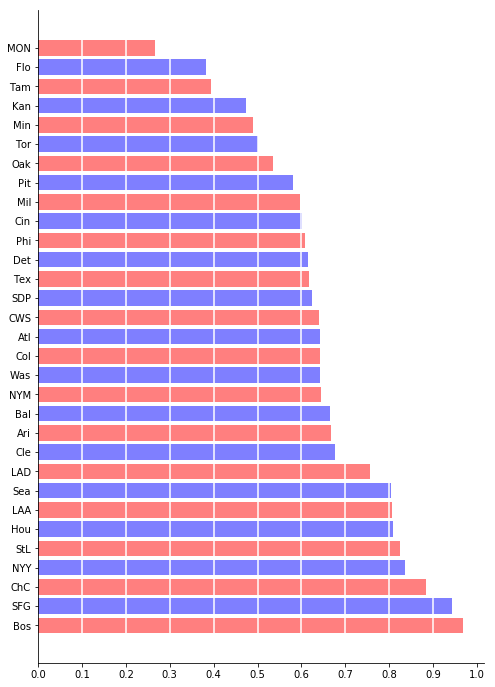

In [17]:
# Plot average attendance ratios by home team
fig, ax = plt.subplots(figsize=(8,12))
ax.barh('home', 'propmaxatt', data=team_att, alpha=0.5, color=['red','blue']*15)
ax.set_xticks([0.1*i for i in range(11)])
for i in [0.1*i for i in range(1,11)]:
    plt.axvline(x=i, color='white')
sns.despine()
plt.savefig('attendances.pdf', bbox_inches='tight')
plt.show()